# 模拟

In [2]:
from brian2 import *
%matplotlib inline

INFO       Cache size for target 'cython': 1301565658 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\kyle\.cython\brian_extensions' directory. [brian2]


### 一个由泊松尖峰神经元驱动的泄漏积分和发射神经元的发射率如何根据其膜时间常数而变化？
- #### 膜时间常数 是衰减的特征时间。 对于典型的神经元，它一般在10ms的范围内，这与大约1ms的脉冲持续时间相比，显得相当长

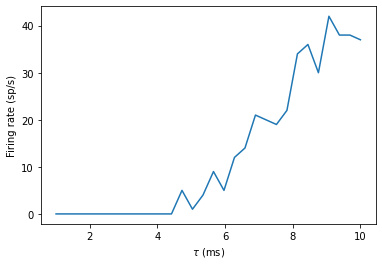

In [2]:
# remember, this is here for running separate simulations in the same notebook
start_scope()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants（在时间常数范围内迭代）
for tau in tau_range:
    # Construct the network each time（每次都构建网络）
    P = PoissonGroup(num_inputs, rates=input_rate)  # 泊松尖峰神经元
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

## 运行速度有点慢。原因是对于每个循环，您都是从头开始重新创建对象。我们可以通过设置一次网络来改善这一点。我们在循环之前存储网络状态的副本，并在每次迭代开始时恢复它

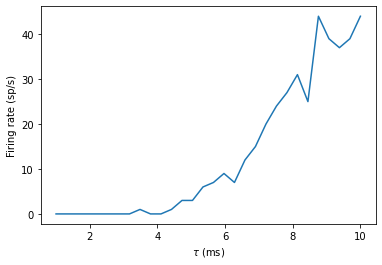

In [3]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)   # 泊松尖峰神经元
# 泄漏积分
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

### 输出曲线非常嘈杂，并且不会像我们预期的那样单调增加。噪音来自我们每次重新运行泊松群的事实。如果我们只想看到时间常数的影响，我们可以确保每次的尖峰都是相同的（尽管请注意，实际上，您应该进行多次运行并取平均值）。为此，我们只运行泊松组一次，记录其尖峰，然后创建一个新的 SpikeGeneratorGroup，每次都输出这些记录的尖峰

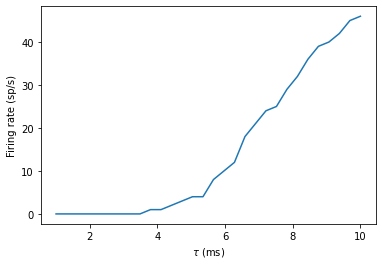

In [4]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
'''
在下面的代码中，我们创建了Network对象。原因是在循环中，如果我们只是调用
run它会尝试模拟所有对象，包括泊松神经元P，我们只想运行一次。我们Network
用来明确指定我们想要包含哪些对象。
'''
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

#### 现在噪声要少得多，而且它会单调增加，因为每次输入尖峰都是相同的，这意味着我们看到的是时间常数的影响，而不是随机尖峰
### 简单地复制该输出神经元并将时间常数作为组的参数，训练速度又快了很多

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


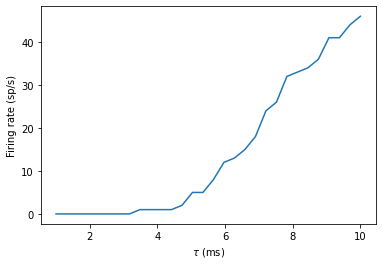

In [5]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)
# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Now we can just run once with no loop
run(1*second)
output_rates = M.count/second # firing rate is count/duration
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

### 通过快速查看尖峰间隔的均值和标准差如何取决于时间常数来结束此示例

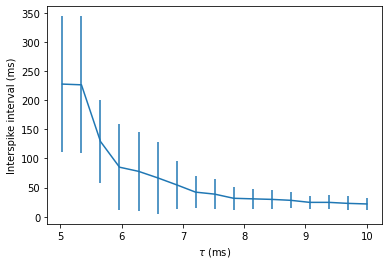

In [6]:
# 使用了spike_trains()的SpikeMonitor方法。
#这是一个字典，键是神经元的索引，值是该神经元的尖峰时间数组。
trains = M.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

## 在运行中改变
- ### 想象一个实验，您将电流注入神经元，并每 10 毫秒随机改变幅度。让我们看看我们是否可以使用 Hodgkin-Huxley 型神经元对其进行建模

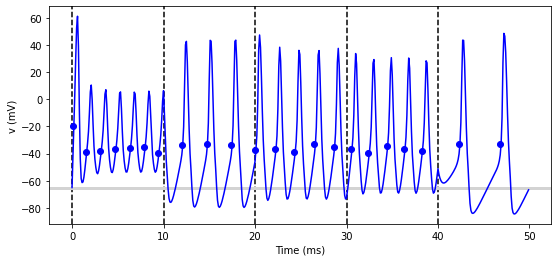

In [7]:
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

### 在上面的代码中，我们使用了多次运行的循环来实现这一点。这很好，但这不是最有效的方法，因为每次我们调用run时，我们都必须做很多初始化工作，这会减慢一切。它也不适用于更高效的 Brian 独立模式。下面是另一种方式。

In [4]:
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
# we keep the loop just to draw the vertical lines
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

NameError: name 'eqs_HH' is not defined

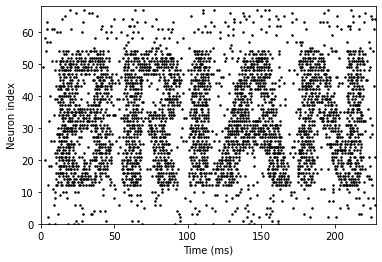

In [12]:
start_scope()
from matplotlib.image import imread
img = (1-imread('brian.png'))[::-1, :, 0].T
num_samples, N = img.shape
ta = TimedArray(img, dt=1*ms) # 228
A = 1.5
tau = 2*ms
eqs = '''
dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
'''
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
M = SpikeMonitor(G)
run(num_samples*ms)
plot(M.t/ms, M.i, '.k', ms=3)
xlim(0, num_samples)
ylim(0, N)
xlabel('Time (ms)')
ylabel('Neuron index');

In [ ]:
start_scope()
from matplotlib.image import imread
img = (1-imread('brian.png'))[::-1, :, 0].T
num_samples, N = img.shape
ta = TimedArray(img, dt=1*ms) # 228
A = 1.5
tau = 2*ms
eqs = '''
dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
'''
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
M = SpikeMonitor(G)
run(num_samples*ms)
plot(M.t/ms, M.i, '.k', ms=3)
xlim(0, num_samples)
ylim(0, N)
xlabel('Time (ms)')
ylabel('Neuron index');